03717357-Gregory Ollivierre-part a with min max scaling

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
pd.options.mode.chained_assignment = None

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("data_a.csv").drop('Unnamed: 0',axis=1)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [4]:
#lets check each of the text based columns and make sure no wierd data
for col in df.columns:
    if df[col].dtype == 'object':
        print(col,df[col].unique())

cut ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
color ['E' 'I' 'J' 'H' 'F' 'G' 'D']
clarity ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


In [5]:
# lets check all rows for missing data
df.isnull().any().any()

False

In [6]:
#ok so lets encode those object columns
#lets assume an Ideal cut has a higher wieighting than a fair cut
df2 = df.copy()
df2['cut'] = df['cut'].apply(lambda x: {"Ideal":5,"Premium":4,"Very Good":3,"Good":2,"Fair":1}[x])
df2['color'] = df['color'].apply(lambda x : {'D':7,'E':6,'F':5,'G':4,'H':3,'I':2,'J':1}[x])
df2['clarity'] = df['clarity'].apply(lambda x : dict(zip(['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF'],\
                                                [1,2,3,4,5,6,7,8]))[x])
# lets also apply min max scaling
for col in df2.columns:
    df2[col] = (df2[col] - df2[col].min()) / (df2[col].max() - df2[col].min()) + 1 # avoid division by zero
df2.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,1.124312,1.726024,1.567634,1.435860,1.520817,1.278023,1.194994,1.533627,1.097360,1.111281
std,0.098547,0.279150,0.283517,0.235305,0.039795,0.042971,0.215680,0.104447,0.019391,0.022192
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.041580,1.500000,1.333333,1.285714,1.500000,1.250000,1.033735,1.438547,1.080136,1.091509
50%,1.103950,1.750000,1.500000,1.428571,1.522222,1.269231,1.112180,1.530726,1.096944,1.111006
75%,1.174636,2.000000,1.833333,1.571429,1.541667,1.307692,1.270219,1.608939,1.111036,1.127044
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [7]:
# lets shuffle and setup our target and inputs
df2 = df2.sample(frac=1)
target = df2['price']
inputs = df2.drop(['price'],axis=1)

In [8]:
X = inputs.values
y = target.values
k_fold = KFold(n_splits=5)
k_fold.get_n_splits(X)
errors = []
for train_idx, test_idx in k_fold.split(X):
    train_X, test_X = X[train_idx], X[test_idx]
    train_y, test_y = y[train_idx], y[test_idx]
    lr = linear_model.Ridge()
    lr.fit(train_X, train_y)
    predictions = lr.predict(test_X)
    error = np.mean(np.abs(predictions - test_y)/ test_y  * 100) # mean average percentage error
    errors.append(error)
print(np.mean(errors))
print(np.std(errors))
print(errors)

3.503959213381086
0.030153635514114003
[3.500587475232761, 3.5443728365345573, 3.5106343257610058, 3.512934414301081, 3.4512670150760267]


In [9]:
lr.coef_

array([ 2.61786969,  0.02747708,  0.10457986,  0.19232124, -0.12506639,
       -0.06224727, -0.32925654,  0.03672197, -0.04768929])

This average percentage error is quite good and low.

[9/9] features ████████████████████ Time elapsed: 0 seconds

(<matplotlib.figure.Figure at 0x15e6693bdd8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x15e66c7d4e0>)

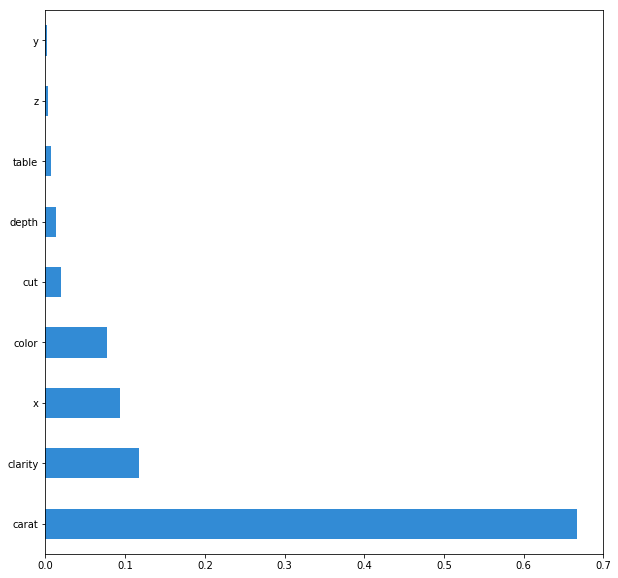

In [10]:
model = InMemoryModel(lr.predict, examples = X)
interpreter = Interpretation(X, feature_names=inputs.columns)
matplotlib.rcParams['figure.figsize'] = [10, 10]
interpreter.feature_importance.plot_feature_importance(model)

so we see that carat size is buy and large the most significant feature affecting Diamond price.